In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject


### 读取数据

In [2]:
mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
len(mnist_train)

2

In [4]:
mnist_train[0].shape

(60000, 28, 28)

In [5]:
mnist_train[1].shape

(60000,)

In [6]:
set(mnist_train[1])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

从上述分析可以看到，mnist_train由features和label构成，包含60000张图片，每张图片是28*28像素，而图片的类型一共有10种

In [7]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [8]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

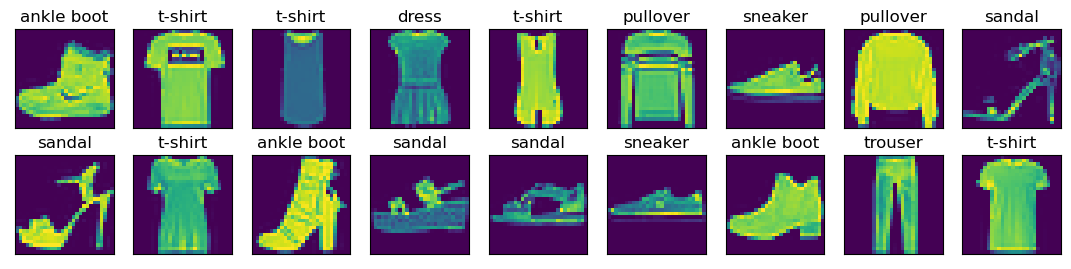

In [9]:
X = tf.constant(mnist_train[0][:18])
y = tf.constant(mnist_train[1][:18])
show_images(X, 2, 9, titles=get_fashion_mnist_labels(y));

In [10]:
batch_size = 256
train_iter = tf.data.Dataset.from_tensor_slices(mnist_train).batch(batch_size).shuffle(len(mnist_train[0]))

In [11]:
for data in train_iter:
    print(data)
    break

(<tf.Tensor: shape=(256, 28, 28), dtype=uint8, numpy=
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

将上述组件整合

In [71]:
def load_data_fashion_mnist(batch_size, resize=None):
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # 将所有的数字除以255，使得所有像素值位于0-1之间，并在最后添加一个批处理维度；将标签转化为int32
    process = lambda X,y : (tf.expand_dims(X, axis=3)/255, tf.cast(y, dtype='int32'))

    resize_fn = lambda X,y : (tf.image.resize_with_pad(X, resize, resize) if resize else X,y)
    
    # *mnist_train相当于(mnist_train[0],mnist_train[1])
    return(
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(batch_size).map(resize_fn))

In [57]:
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

(256, 28, 28, 1) <dtype: 'float32'> (256,) <dtype: 'int32'>


### 初始化模型参数

In [124]:
train_iter, test_iter = load_data_fashion_mnist(batch_size=256)

In [125]:
num_input = 28*28 # 将图像的像素平摊
num_output =10 # 10个类别

In [126]:
W = tf.Variable(tf.random.normal(shape=(num_input, num_output), mean=0, stddev=0.01))
b = tf.Variable(tf.zeros(shape=(num_output)))

### 定义softmax操作

In [127]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, axis=1, keepdims=True)
    return X_exp/partition

### 定义模型 

In [128]:
def net(X):
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)

### 定义损失函数

In [129]:
def cross_entropy(y_hat, y):
    # tf.boolean_mask用于找到与one_hot向量中1元素位置对应的那个元素
    return -tf.math.log(tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

### 分类精度

In [130]:
def accuracy(y_hat, y):
    '''计算预测正确的数量'''
    # 当y_hat的维度超过1，且y的类别数大于1
    if len(y_hat.shape) > 1 and y_hat.shape[1] >1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

In [131]:
class Accumulator:  
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [132]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上的模型的精度"""
    metric = Accumulator(2) # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X),y), y.shape[0])
    return metric[0]/metric[1]


### 训练

In [133]:
class Updater():  
    """用小批量随机梯度下降法更新参数"""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr
    
    def __call__(self, batch_size, grads):
        self.sgd(self.params, grads, self.lr, batch_size)

    def sgd(self, params, grads, lr, batch_size):
        for param, grad in zip(params, grads):
            param.assign_sub(lr*grad/batch_size)


In [134]:
def train_epoch(net, train_iter, loss, updater):
    metric = Accumulator(3) # 训练损失总和、训练准确度总和、样本数
    for X, y in train_iter:
        with tf.GradientTape() as tape:
            y_hat = net(X)
            l = loss(y_hat, y)
        updater(X.shape[0], tape.gradient(l, updater.params)) # 这里传入的参数是__call__所需要的参数
        l_sum = tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    return metric[0] / metric[2], metric[1]/metric[2]

In [135]:
def begin_training(net, train_iter, test_iter, loss, num_epochs, updater):
    """模型训练"""
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss # 当train_loss大于0.5时抛出异常，异常信息为train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [136]:
num_epochs = 10
updater = Updater([W,b],0.1)
begin_training(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### 预测

In [137]:
def predict(net, test_iter, n=6):
    """预测标签"""
    for X, y in test_iter: # test_iter没有batch切分所以break
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])
    

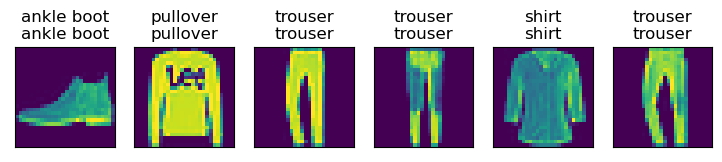

In [138]:
predict(net, test_iter)